In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
import math

### Set - Up

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Parameters
noise_dim = 10
image_dim = 28
batch_size = 64

max_translate = 6
max_rotation = 20

In [ ]:
# Load MNIST and extract one sample per class
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

base_images, base_labels = [], []
seen_classes = set()
for img, label in train_dataset:
    if label not in seen_classes:
        base_images.append(img)
        base_labels.append(label)
        seen_classes.add(label)
    if len(seen_classes) == 10:
        break
base_images = torch.stack(base_images, dim=0).to(device)
base_labels = torch.tensor(base_labels, dtype=torch.long).to(device)

In [ ]:
# Define Sampler MLP
class SamplerMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784 + noise_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )
        self.net[-1].weight.data.uniform_(-0.1, 0.1)
        self.net[-1].bias.data.zero_()

    def forward(self, x):
        params = self.net(x)
        return torch.stack([
            max_translate * torch.tanh(params[:, 0]),
            max_translate * torch.tanh(params[:, 1]),
            max_rotation * torch.tanh(params[:, 2]),
        ], dim=1)

In [ ]:
# Define Classifier CNN
class ClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
# Transformation function
def apply_transform(images, params, current_step, warmup_steps):
    B = images.size(0)
    tx, ty, rot_deg = params[:, 0], params[:, 1], params[:, 2]

    if warmup_steps > 0:
        progress = torch.tensor(current_step / warmup_steps, device=device).clamp(0, 1)
        tx = tx * progress
        ty = ty * progress
        rot_deg = rot_deg * progress

    rot_rad = torch.deg2rad(rot_deg)
    cos, sin = torch.cos(rot_rad), torch.sin(rot_rad)

    affine_mat = torch.zeros(B, 3, 3, device=device)
    affine_mat[:, 0, 0] = cos
    affine_mat[:, 0, 1] = -sin
    affine_mat[:, 1, 0] = sin
    affine_mat[:, 1, 1] = cos
    affine_mat[:, 0, 2] = tx / 14.0
    affine_mat[:, 1, 2] = ty / 14.0
    affine_mat[:, 2, 2] = 1.0

    theta = torch.inverse(affine_mat)[:, :2, :]
    grid = F.affine_grid(theta, images.size(), align_corners=False)
    return F.grid_sample(images, grid, align_corners=False, padding_mode='border')

In [ ]:
# Evaluation function
def evaluate(model):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

In [ ]:
# # Visualization function
# def visualize_augmentations(num_samples=5, sampler, online_epochs, warmup_steps):
#     sampler.eval()
#     with torch.no_grad():
#         fig, axs = plt.subplots(10, num_samples+1, figsize=(15, 25))
#         for digit in range(10):
#             img = base_images[digit].cpu().numpy().squeeze()
#             axs[digit, 0].imshow(img, cmap='gray')
#             axs[digit, 0].axis('off')

#             for i in range(num_samples):
#                 noise = torch.randn(1, noise_dim, device=device)

#                 # We need to make them both 1D before concatenating:
#                 params = sampler(torch.cat([base_images[digit].flatten(), noise.flatten()], 0).unsqueeze(0))

#                 # and then unsqueeze to add a batch dimension
#                 aug_img = apply_transform(base_images[digit].unsqueeze(0), params, online_epochs, warmup_steps)  # Use max step for full transform
#                 axs[digit, i+1].imshow(aug_img.squeeze().cpu().numpy(), cmap='gray')
#                 axs[digit, i+1].axis('off')
#         plt.tight_layout()
#         plt.show()
#     sampler.train()

In [ ]:
def online_training(steps, warmup_steps, sampler, optimizer_s, classifier, optimizer_c, scheduler_c, criterion, eval_interval):
    print("Starting online training...")

    loss_history, s_loss_history, accuracy_history = [], [], []

    for step in range(1, steps + 1):
        idx = torch.randint(0, 10, (batch_size,), device=device)
        batch_images = base_images[idx]
        batch_labels = base_labels[idx]
        noise = torch.randn(batch_size, noise_dim, device=device)

        with torch.no_grad():
            params = sampler(torch.cat([batch_images.view(batch_size, -1), noise], 1))

        aug_images = apply_transform(batch_images, params, step, warmup_steps)

        optimizer_c.zero_grad()
        logits = classifier(aug_images)
        loss_c = criterion(logits, batch_labels)
        loss_c.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)
        optimizer_c.step()
        scheduler_c.step()

        if step > warmup_steps:
            for p in classifier.parameters():
                p.requires_grad = False

            params = sampler(torch.cat([batch_images.view(batch_size, -1), noise], 1))
            aug_images = apply_transform(batch_images, params, step, warmup_steps)
            logits = classifier(aug_images)
            loss_s = -criterion(logits, batch_labels)

            optimizer_s.zero_grad()
            loss_s.backward()
            torch.nn.utils.clip_grad_norm_(sampler.parameters(), 1.0)
            optimizer_s.step()

            for p in classifier.parameters():
                p.requires_grad = True
        else:
            loss_s = torch.tensor(0.0)

        if step % eval_interval == 0:
            acc = evaluate(classifier)
            # print(f"Online Step {step:4d} | Class Loss: {loss_c.item():.4f} | Sampler Loss: {loss_s.item():.4f} | Accuracy: {acc*100:.2f}%")
            loss_history.append(loss_c.item())
            s_loss_history.append(loss_s.item())
            accuracy_history.append(acc)

    return accuracy_history, loss_history, s_loss_history

In [ ]:
def disk_training(num_epochs, classifier, optimizer, scheduler, criterion, eval_interval, max_steps):
    print("Starting disk training...")

    loss_history, accuracy_history = [], []
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    step = 0
    for epoch in range(1, num_epochs + 1):
        for batch_images, batch_labels in train_loader:
            if step >= max_steps:
                break
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            logits = classifier(batch_images)
            loss = criterion(logits, batch_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            step += 1

            if step % eval_interval == 0:
                acc = evaluate(classifier)
                # print(f"Disk Step {step:4d} | Classifier Loss: {loss.item():.4f} | Accuracy: {acc*100:.2f}%")
                loss_history.append(loss.item())
                accuracy_history.append(acc)

    return accuracy_history, loss_history

### Experiment

In [ ]:
def run(startup_proportion, total_training_steps, eval_interval):
    # Initialize models and optimizers
    sampler = SamplerMLP().to(device)
    optimizer_s = torch.optim.Adam(sampler.parameters(), lr=1e-4)

    classifier = ClassifierCNN().to(device)
    optimizer_c = torch.optim.Adam(classifier.parameters(), lr=3e-4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    steps_per_epoch = len(train_loader)

    # Calculate how much training is online vs disk
    online_steps = int(startup_proportion * total_training_steps)
    disk_steps = total_training_steps - online_steps

    disk_epochs = math.ceil(disk_steps / steps_per_epoch)
    # print('DISK EPOCHS:', disk_epochs)

    scheduler_c = torch.optim.lr_scheduler.OneCycleLR(
        optimizer_c, max_lr=3e-4, total_steps=total_training_steps
    )

    criterion = nn.CrossEntropyLoss()

    warmup_steps = max(1, online_steps // 4)

    start = time.time()

    # Online training
    accuracy_history, loss_history, s_loss_history = online_training(
        online_steps, warmup_steps, sampler, optimizer_s,
        classifier, optimizer_c, scheduler_c, criterion, eval_interval
    )

    # Disk training
    d_accuracy_history, d_loss_history = disk_training(
        disk_epochs, classifier, optimizer_c, scheduler_c, criterion, eval_interval, disk_steps
    )

    end = time.time()

    # Combine histories
    accuracy = accuracy_history + d_accuracy_history
    loss = loss_history + d_loss_history
    s_loss = s_loss_history + [0 for _ in range(len(d_loss_history))]

    elapsed_time = end - start

    return elapsed_time, accuracy, loss, s_loss


In [ ]:
total_steps  = 200
eval_interval = 5
percentages   = [round(0.1 * p, 2) for p in range(10)]

times        = {}
losses       = {}
f_losses     = {}
s_losses     = {}
accuracies   = {}
f_accuracies = {}

for percent in percentages:
  print()
  print("Testing ", percent*100, "% online....")
  t, a, l, s_l = run(percent, total_steps, eval_interval)

  times[percent]        = t
  losses[percent]       = l
  s_losses[percent]     = s_l
  accuracies[percent]   = a

  f_losses[percent]     = l[-1]
  f_accuracies[percent] = a[-1]


Testing  0.0 % online....
Starting online training...
Starting disk training...

Testing  1.0 % online....
Starting online training...
Starting disk training...

Testing  2.0 % online....
Starting online training...
Starting disk training...

Testing  3.0 % online....
Starting online training...
Starting disk training...

Testing  4.0 % online....
Starting online training...
Starting disk training...

Testing  5.0 % online....
Starting online training...
Starting disk training...

Testing  6.0 % online....
Starting online training...
Starting disk training...

Testing  7.0 % online....
Starting online training...
Starting disk training...

Testing  8.0 % online....
Starting online training...
Starting disk training...

Testing  9.0 % online....
Starting online training...
Starting disk training...


### Analysis

Plot times

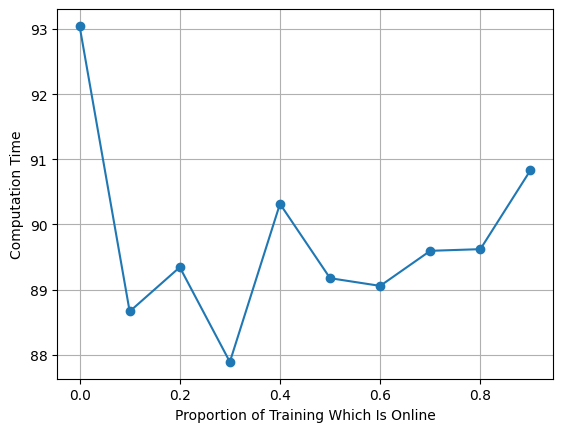

In [ ]:
x  = list(times.keys())
tm = list(times.values())

plt.plot(x, tm, marker='o')
plt.xlabel('Proportion of Training Which Is Online')
plt.ylabel('Computation Time')
plt.title('')
plt.grid(True)
plt.show()

Plot Final Accuracies

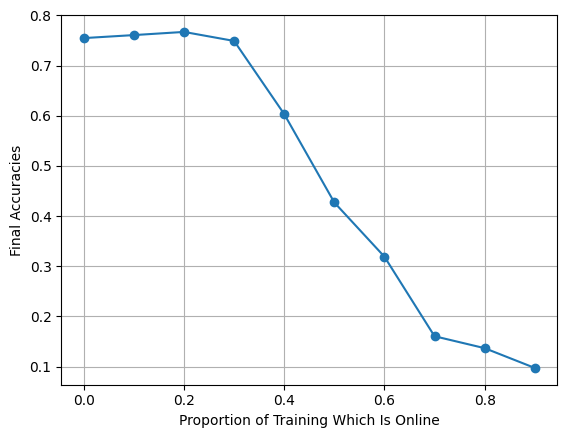

In [ ]:
fa = list(f_accuracies.values())

plt.plot(x, fa, marker='o')
plt.xlabel('Proportion of Training Which Is Online')
plt.ylabel('Final Accuracies')
plt.title('')
plt.grid(True)
plt.show()

Plot Final Losses

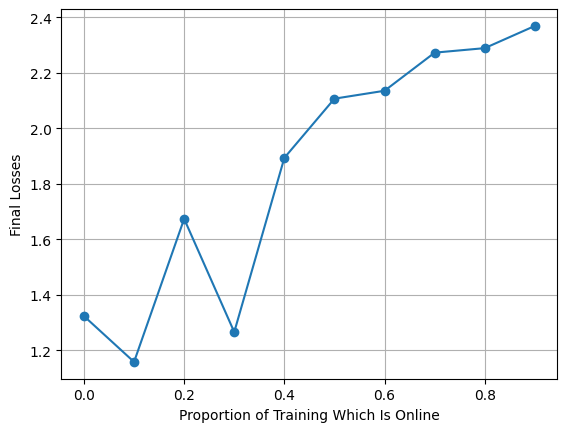

In [ ]:
fl = list(f_losses.values())

plt.plot(x, fl, marker='o')
plt.xlabel('Proportion of Training Which Is Online')
plt.ylabel('Final Losses')
plt.title('')
plt.grid(True)
plt.show()